# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [147]:
ls

AZDIAS_Feature_Summary.csv
ArvatoProjectWorkbook.ipynb
DIAS Attributes - Values 2017.xlsx
DIAS Information Levels - Attributes 2017.xlsx
Udacity_AZDIAS_052018.csv
Udacity_CUSTOMERS_052018.csv
Udacity_MAILOUT_052018_TEST.csv
Udacity_MAILOUT_052018_TRAIN.csv


In [360]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer,StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier , AdaBoostClassifier , 
from sklearn.svm import SVC
# magic word for producing visualizations in notebook
%matplotlib inline

In [149]:
azdias_orig = pd.read_csv('Udacity_AZDIAS_052018.csv')
customers_orig = pd.read_csv('Udacity_CUSTOMERS_052018.csv')

In [150]:
azdias_orig.shape

(891221, 367)

In [151]:
customers_orig.shape

(191652, 370)

In [152]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv')

In [153]:
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')

In [396]:
azdias.head()

,Unnamed: 0,LNR,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,9.0,0.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,1.0,20.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [397]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Part 0.1: Convert Missing Value Codes to NaNs

In [155]:
attr_df = pd.read_excel('DIAS Attributes - Values 2017.xlsx',header=1,delimiter=';')

In [156]:
attr_df.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [157]:
attr_df.head(10)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,NaN,1,< 30 years
7,NaN,NaN,NaN,2,30 - 45 years
8,NaN,NaN,NaN,3,46 - 60 years
9,NaN,NaN,NaN,4,> 60 years


In [158]:
unknowns_df = attr_df[attr_df.Meaning == 'unknown'][['Attribute','Value']].reset_index().drop(columns='index')

In [159]:
unknowns_df.head()

,Attribute,Value
0,AGER_TYP,-1
1,ALTERSKATEGORIE_GROB,"-1, 0"
2,ANREDE_KZ,"-1, 0"
3,BALLRAUM,-1
4,BIP_FLAG,-1


In [160]:
azdias.shape

(891221, 367)

In [161]:
unknowns_df.head()

,Attribute,Value
0,AGER_TYP,-1
1,ALTERSKATEGORIE_GROB,"-1, 0"
2,ANREDE_KZ,"-1, 0"
3,BALLRAUM,-1
4,BIP_FLAG,-1


In [162]:
attr_df.columns

Index(['Unnamed: 0', 'Attribute', 'Description', 'Value', 'Meaning'], dtype='object')

In [163]:
azdias.isnull().sum().sum()

33492923

In [164]:
for i in np.arange(len(unknowns_df)):
    if unknowns_df.Attribute[i] in azdias.columns:
        if type(unknowns_df.Value[i]) == str :
            miss_tr = unknowns_df.Value[i].split(',')
            for r in miss_tr:
                try:
                    azdias[unknowns_df.Attribute[i]].replace(int(r),np.nan,inplace=True)
                except: #if it's a character
                    azdias[unknowns_df.Attribute[i]].replace(r,np.nan,inplace=True)
        else:
            try:
                azdias[unknowns_df.Attribute[i]].replace(int(unknowns_df.Value[i]),np.nan,inplace=True)
            except: #if it's a character
                azdias[unknowns_df.Attribute[i]].replace(unknowns_df.Value[i],np.nan,inplace=True)

In [165]:
azdias.isnull().sum().sum()

36835799

### Part 0.2 : Assess Missing Data in Each Column

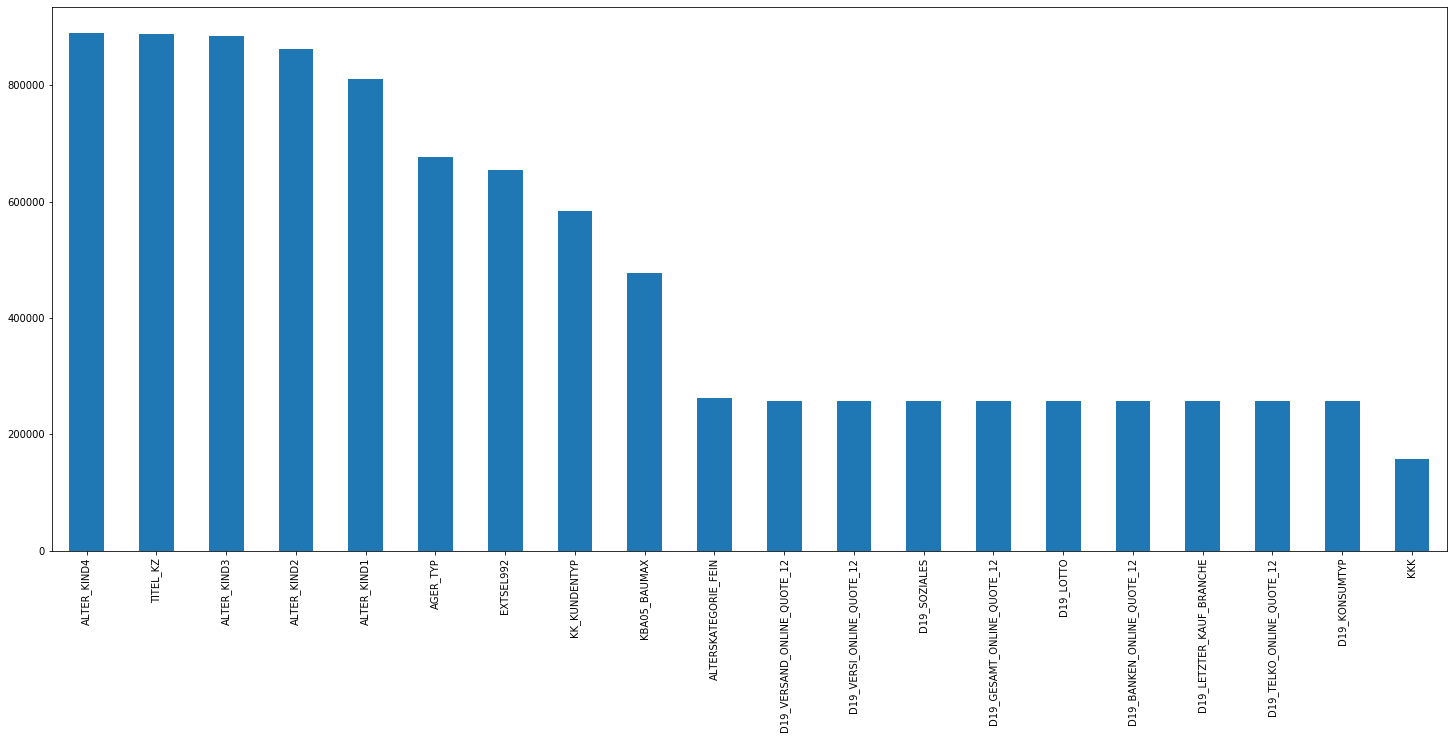

In [166]:
azdias.isnull().sum().sort_values(ascending=False)[:20].plot.bar(figsize=(25,10));

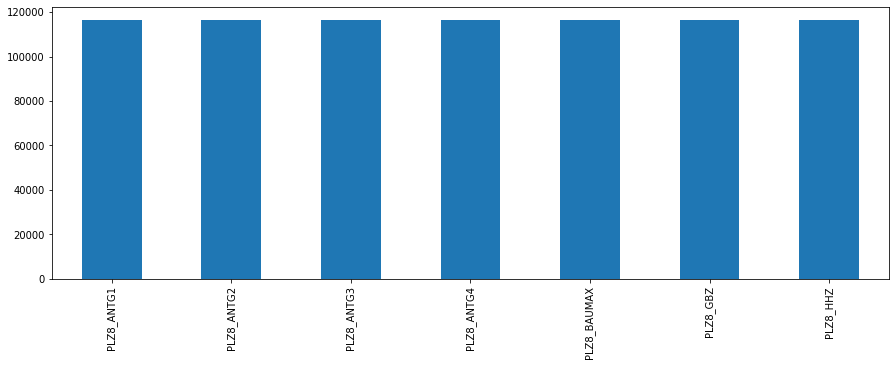

In [167]:
filter_col_1 = [col for col in azdias if col.startswith('PLZ8')]
azdias[filter_col_1].isnull().sum().plot.bar(figsize=(15,5));

In [168]:
print(f'Percentage of missing values for columns that starts with "PLZ8_" is = {round(azdias[filter_col_1].isnull().sum().sum()/azdias[filter_col_1].count().sum(),3)}%')

Percentage of missing values for columns that starts with "PLZ8_" is = 0.15%


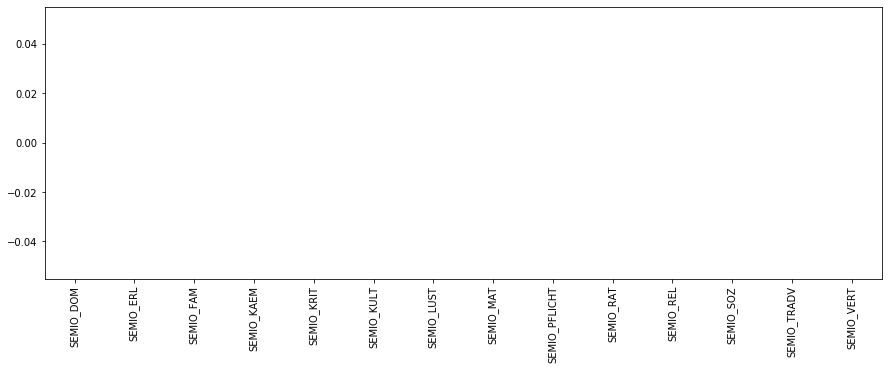

In [169]:
filter_col_2 = [col for col in azdias if col.startswith('SEMIO_')]
azdias[filter_col_2].isnull().sum().plot.bar(figsize=(15,5));

In [170]:
print(f'Percentage of missing values for columns that starts with "SEMIO_" is = {round(azdias[filter_col_2].isnull().sum().sum()/azdias[filter_col_2].count().sum(),3)}%')

Percentage of missing values for columns that starts with "SEMIO_" is = 0.0%


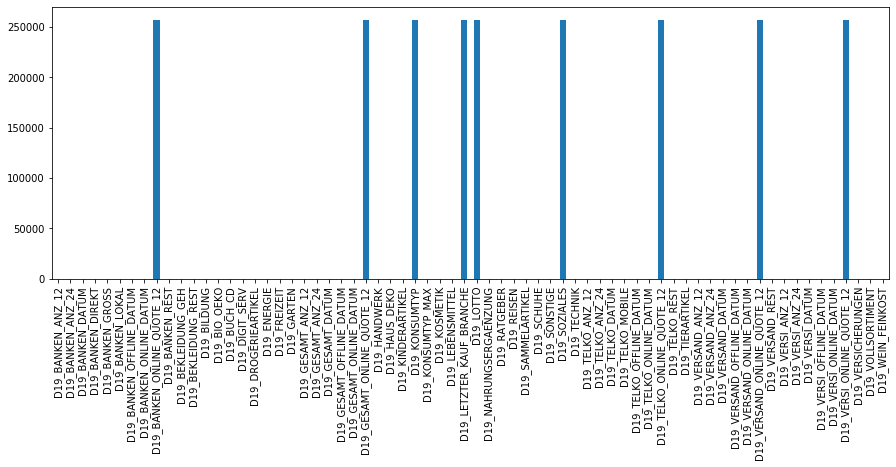

In [171]:
filter_col_3 = [col for col in azdias if col.startswith('D19')]
azdias[filter_col_3].isnull().sum().plot.bar(figsize=(15,5));

In [172]:
print(f'Percentage of missing values for columns that starts with "D19" is = {round(azdias[filter_col_3].isnull().sum().sum()/azdias[filter_col_3].count().sum(),3)}%')

Percentage of missing values for columns that starts with "D19" is = 0.04%


In [173]:
drop_c = azdias.columns[(azdias.isnull().mean()>0.2)].tolist()
drop_c

['AGER_TYP',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_SOZIALES',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ONLINE_QUOTE_12',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ']

In [174]:
azdias.drop(columns= drop_c , inplace = True)

In [175]:
azdias.shape

(891221, 348)

In [176]:
azdias.head()

,Unnamed: 0,LNR,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,9.0,0.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,1.0,20.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


### Part 0.3 : Assess Missing Data in Each Row

In [177]:
azdias_hm = azdias[azdias.isnull().sum(axis=1)>=74].copy()
azdias_lm = azdias[azdias.isnull().sum(axis=1)<74].copy()

In [178]:
azdias_hm[:6]

,Unnamed: 0,LNR,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
11,11,645169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
14,14,612565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,3
15,15,612569,9.0,11.0,1.0,0.0,0.0,1.0,1.0,0.0,...,4.0,6.0,6.0,3.0,6.0,4.0,3.0,3,2,4
17,17,612577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
20,20,612594,7.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,NaN,8.0,11.0,10.0,3.0,4.0,5.0,3,2,2


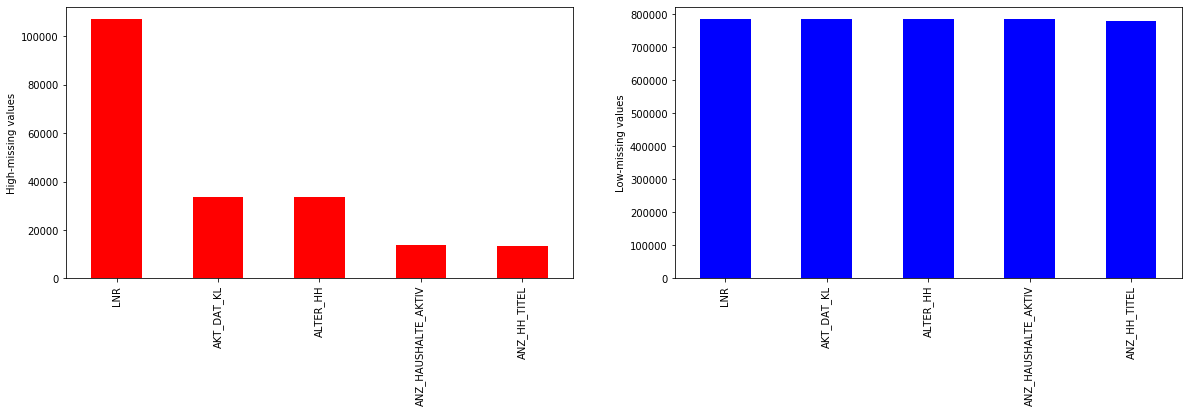

In [399]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
azdias_hm.iloc[:,1:6].count().plot.bar(color='red');
#plt.ylim(50000,900000);
plt.ylabel('High-missing values');
plt.subplot(1,2,2)
azdias_lm.iloc[:,1:6].count().plot.bar(color='blue');
#plt.ylim(50000,900000);
plt.ylabel('Low-missing values');

In [180]:
azdias.isnull().sum(axis=1).median()

0.0

In [181]:
c_rows = azdias_lm.columns[:10]

### Part 0.4 : Re-encode Categorical Columns

In [182]:
ls

AZDIAS_Feature_Summary.csv
ArvatoProjectWorkbook.ipynb
DIAS Attributes - Values 2017.xlsx
DIAS Information Levels - Attributes 2017.xlsx
Udacity_AZDIAS_052018.csv
Udacity_CUSTOMERS_052018.csv
Udacity_MAILOUT_052018_TEST.csv
Udacity_MAILOUT_052018_TRAIN.csv


In [183]:
c_list=feat_info.query('type =="categorical"').attribute.tolist()

In [184]:
c_list

['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [185]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [186]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
mlc=[]
for att in c_list:
    if att in azdias_lm.columns:
        print(att,azdias_lm[att].nunique(),'\t',azdias_lm[att].dtype)
        #Printing categorical columns,number of levels and data types
        
        if azdias_lm[att].nunique()>2:
            mlc.append(att) 
            #list attributes with more than two categories

ANREDE_KZ 2 	 int64
CJT_GESAMTTYP 6 	 float64
FINANZTYP 6 	 int64
GFK_URLAUBERTYP 12 	 float64
GREEN_AVANTGARDE 2 	 int64
LP_FAMILIE_FEIN 12 	 float64
LP_FAMILIE_GROB 6 	 float64
LP_STATUS_FEIN 10 	 float64
LP_STATUS_GROB 5 	 float64
NATIONALITAET_KZ 3 	 float64
SHOPPER_TYP 4 	 float64
SOHO_KZ 2 	 float64
VERS_TYP 2 	 float64
ZABEOTYP 6 	 int64
GEBAEUDETYP 7 	 float64
OST_WEST_KZ 2 	 object
CAMEO_DEUG_2015 19 	 object
CAMEO_DEU_2015 45 	 object


In [187]:
mlc

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [188]:
azdias_lm['OST_WEST_KZ'].replace({'O':0,'W':1},inplace=True);

In [189]:
azdias_lm['OST_WEST_KZ'].head()

1    1
2    1
3    1
4    1
5    1
Name: OST_WEST_KZ, dtype: int64

In [190]:
azdias_lm.shape

(784267, 348)

In [191]:
# Dropping all mixed columns
azdias_lm.drop(columns = mlc, inplace=True)

### Part 0.5 : Handling Mixed Columns

In [192]:
feat_info.query('type=="mixed"')

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [193]:
# create function to apply the column
def wealth(x):
    if pd.isnull(x) or x == 'XX':
        return np.nan
    else:
        return int(str(x)[0])

def life_stage(x):
    if pd.isnull(x) or x == 'XX':
        return np.nan
    else:
        return int(str(x)[1])

In [194]:
azdias_lm.CAMEO_INTL_2015.unique()

array([51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0, 41.0,
       34.0, 55.0, 25.0, nan, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [195]:
#apply the functions
azdias_lm['CAMEO_INTL_wealth']=azdias_lm.CAMEO_INTL_2015.apply(wealth)
azdias_lm['CAMEO_INTL_life_stage']=azdias_lm.CAMEO_INTL_2015.apply(life_stage)

In [196]:
azdias_lm['CAMEO_INTL_wealth'].head()

1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
Name: CAMEO_INTL_wealth, dtype: float64

In [197]:
azdias_lm['CAMEO_INTL_life_stage'].head()

1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
Name: CAMEO_INTL_life_stage, dtype: float64

In [198]:
#Drop the original column
azdias_lm.drop(columns='CAMEO_INTL_2015',inplace=True)

In [199]:
# 1 for residenial and 0 for business
type_of_bulding={1:1,2:1,3:1,4:1,5:0}
azdias_lm.PLZ8_BAUMAX.replace(type_of_bulding,inplace=True)
azdias_lm.rename(columns={'PLZ8_BAUMAX':'type_of_bulding'},inplace=True)

In [200]:
azdias_lm.type_of_bulding.head()

1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
Name: type_of_bulding, dtype: float64

In [201]:
neighborhood_quality={7:np.nan,8:np.nan}
azdias_lm.WOHNLAGE.replace(neighborhood_quality,inplace=True)
azdias_lm.rename(columns={'WOHNLAGE':'neighborhood_quality'},inplace=True)

In [202]:
azdias_lm.neighborhood_quality.head()

1    4.0
2    2.0
3    NaN
4    3.0
5    NaN
Name: neighborhood_quality, dtype: float64

In [203]:
attr_df[attr_df.Meaning == 'unknown'][['Attribute','Value']].reset_index().drop(columns='index')

,Attribute,Value
0,AGER_TYP,-1
1,ALTERSKATEGORIE_GROB,"-1, 0"
2,ANREDE_KZ,"-1, 0"
3,BALLRAUM,-1
4,BIP_FLAG,-1
5,CAMEO_DEUG_2015,-1
6,CAMEO_DEUINTL_2015,-1
7,CJT_GESAMTTYP,0
8,D19_KK_KUNDENTYP,-1
9,EWDICHTE,-1


In [204]:
mdl = feat_info.query('type == "mixed"').attribute.tolist()

In [205]:
for att in mdl:
    try:
        print(azdias_lm[att][0])
    except:
        continue

In [206]:
for att in mdl:
    try:
        azdias_lm.drop(columns=att,inplace=True)
        print(att) #Dropped Mixed columns
    except:
        continue

LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
PRAEGENDE_JUGENDJAHRE


In [207]:
# Drop remaining columns that are objects 
obj_col=[]
for cc in azdias_lm.columns:
    if azdias_lm[cc].dtype == 'object':
        print(cc)
        obj_col.append(cc)
        print(azdias_lm[cc].dtype)
azdias_lm.drop(columns=obj_col, inplace=True)

EINGEFUEGT_AM
object


In [208]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    attr_df = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header = 1, delimiter = ';')
    
    unknowns_df = attr_df[attr_df.Meaning == 'unknown'][['Attribute','Value']].reset_index().drop(columns='index')
    
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')

    for i in np.arange(len(unknowns_df)):
        if unknowns_df.Attribute[i] in df.columns:
            if type(unknowns_df.Value[i]) == str :
                miss_tr = unknowns_df.Value[i].split(',')
                for r in miss_tr:
                    try:
                        df[unknowns_df.Attribute[i]].replace(int(r),np.nan,inplace=True)
                    except: #if it's a character
                        df[unknowns_df.Attribute[i]].replace(r,np.nan,inplace=True)
            else:
                try:
                    df[unknowns_df.Attribute[i]].replace(int(unknowns_df.Value[i]),np.nan,inplace=True)
                except: #if it's a character
                    df[unknowns_df.Attribute[i]].replace(unknowns_df.Value[i],np.nan,inplace=True)

                    
    #Drop columns with missing valuea of more than 40%
    drop_c = ['AGER_TYP', 'ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4',
            'ALTERSKATEGORIE_FEIN','D19_BANKEN_ONLINE_QUOTE_12','D19_GESAMT_ONLINE_QUOTE_12',
            'D19_KONSUMTYP','D19_LETZTER_KAUF_BRANCHE','D19_LOTTO','D19_SOZIALES','D19_TELKO_ONLINE_QUOTE_12',
            'D19_VERSAND_ONLINE_QUOTE_12','D19_VERSI_ONLINE_QUOTE_12','EXTSEL992','KBA05_BAUMAX','KK_KUNDENTYP',
            'TITEL_KZ']
    
    df.drop(columns = drop_c, inplace = True)
    
    #Devide the dataset into two subsets based in rows' missing values:
    df_lm = df[df.isnull().sum(axis=1)<74].copy()


    # Re-encode Binary categorical and drop the rest
    mlc = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN',
         'LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ',
         'SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP',
         'CAMEO_DEUG_2015','CAMEO_DEU_2015']
    
    df_lm['OST_WEST_KZ'].replace({'O':0,'W':1},inplace=True);
    
    df_lm.drop(columns = mlc, inplace = True)
    
    #Re-Encoding Mixed features
    
    # 1- CAMEO_INTL_2015
    def wealth(x):
        if pd.isnull(x) or x == 'XX':
            return np.nan
        else:
            return int(str(x)[0])

    def life_stage(x):
        if pd.isnull(x) or x == 'XX':
            return np.nan
        else:
            return int(str(x)[1])

    df_lm['CAMEO_INTL_wealth'] = df_lm.CAMEO_INTL_2015.apply(wealth)
    df_lm['CAMEO_INTL_life_stage'] = df_lm.CAMEO_INTL_2015.apply(life_stage)
    df_lm.drop(columns='CAMEO_INTL_2015',inplace=True)
    
    # 2- PLZ8_BAUMAX
    type_of_bulding={1:1,2:1,3:1,4:1,5:0}
    df_lm.PLZ8_BAUMAX.replace(type_of_bulding,inplace=True)
    df_lm.rename(columns={'PLZ8_BAUMAX':'type_of_bulding'},inplace=True)
    
    # 3- WOHNLAGE
    neighborhood_quality={7:np.nan,8:np.nan}
    df_lm.WOHNLAGE.replace(neighborhood_quality,inplace=True)
    df_lm.rename(columns={'WOHNLAGE':'neighborhood_quality'},inplace=True)
    
    #Dropping remaining mixed values
    mdl=feat_info.query('type == "mixed"').attribute.tolist()
    
    for att in mdl:
        try:
            df_lm.drop(columns=att,inplace=True)
        except:
            continue
    # Drop remaining columns that are objects 
    obj_col=[]
    for cc in df_lm.columns:
        if df_lm[cc].dtype == 'object':
            obj_col.append(cc)
    
    df_lm.drop(columns=obj_col, inplace=True)
    
    return df_lm

In [209]:
#Check for all values that are numerical 
obj_col=[]
for cc in azdias_lm.columns:
    if azdias_lm[cc].dtype == 'object':
        print(cc)
        obj_col.append(cc)
        print(azdias_lm[cc].dtype)

In [210]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Part 1.1 : Feature Scaling & Imputing

In [211]:
azdias_lm.shape

(784267, 332)

In [212]:
ss = StandardScaler(with_mean=True, with_std=True)
ssdf = pd.DataFrame(ss.fit_transform(azdias_lm))

In [213]:
ssdf.columns = azdias_lm.columns
ssdf.index = azdias_lm.index

In [214]:
im = Imputer(strategy='most_frequent')
idf = pd.DataFrame(im.fit_transform(ssdf))

/Users/hussam/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [215]:
idf.isnull().sum().sum()

0

In [216]:
azdias_cleaned=idf.copy()

### Part 1.2 : Apply PCA

In [217]:
pca = PCA()
pca.fit(azdias_cleaned)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

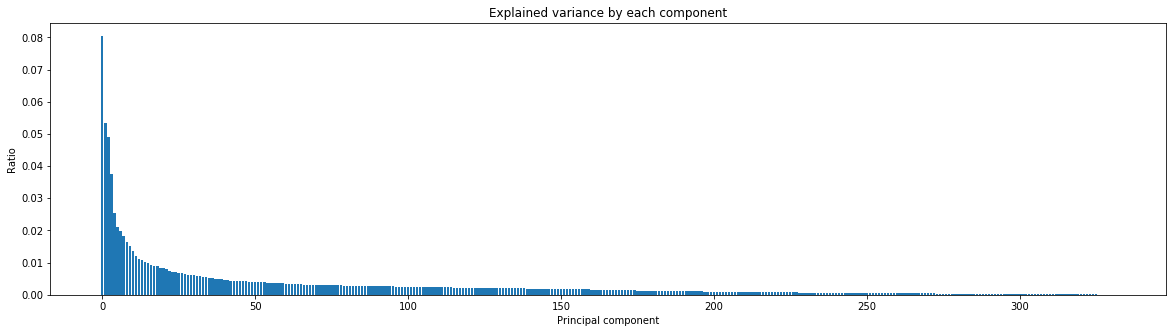

In [218]:
# Investigate the variance accounted by each principal component.
plt.figure(figsize=(20,5))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Explained variance by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio")
plt.show()

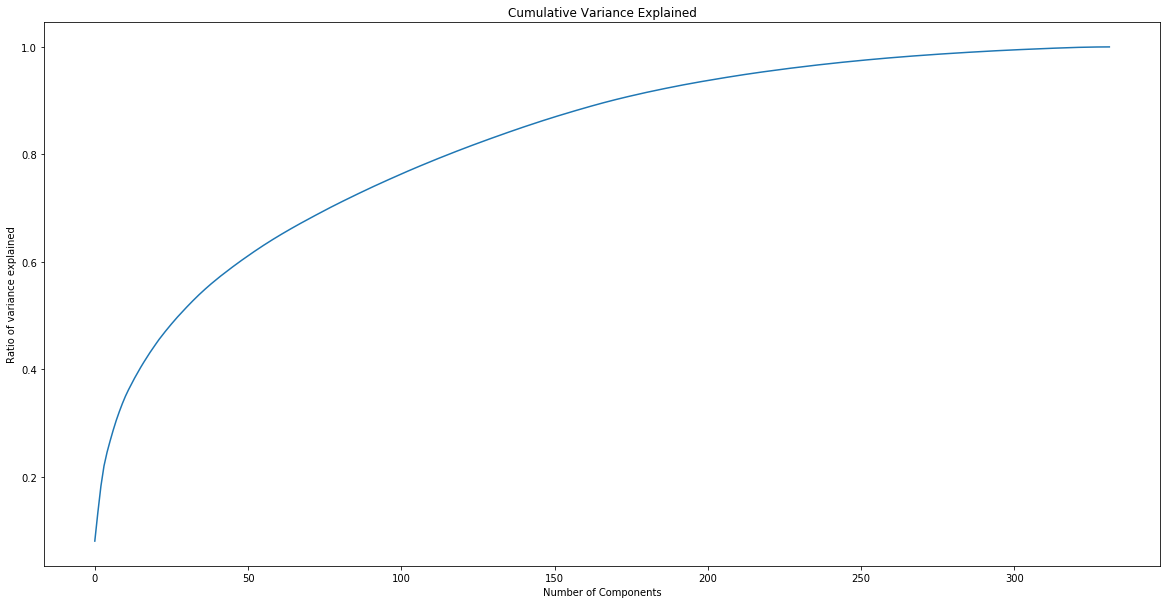

In [219]:
plt.figure(figsize=(20,10))
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()

In [220]:
#Checking for optimal number of components with the 82.5%:

for i in np.arange(len(pca.explained_variance_ratio_)):
    value=pca.explained_variance_ratio_[:i].sum()

    if value >0.825:
        opt_com=i
        print(opt_com)
        break
pca=PCA(n_components=i)
azdias_pca=pd.DataFrame(pca.fit_transform(azdias_cleaned))

128


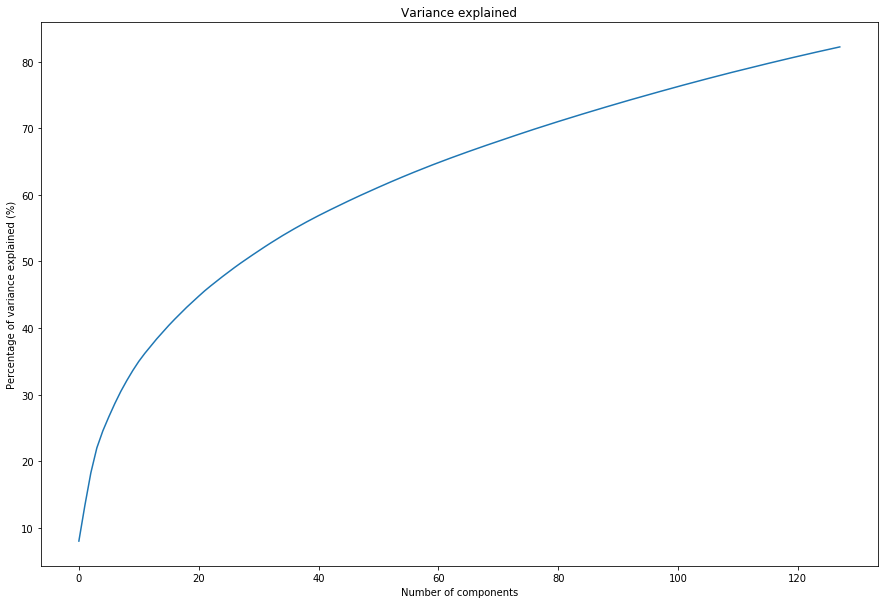

In [221]:
plt.figure(figsize=(15,10))
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_)*100)
plt.title("Variance explained")
plt.xlabel("Number of components")
plt.ylabel("Percentage of variance explained (%)")
plt.show()

In [222]:
pca.explained_variance_ratio_.sum()

0.8219517697205305

In [422]:
def pca_results(full_dataset, pca, dim=2, n_columns=10):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''
	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.iloc[:dim,:n_columns].plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_[:dim]):
		ax.text(i-0.10, ax.get_ylim()[1]+ 0.005, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

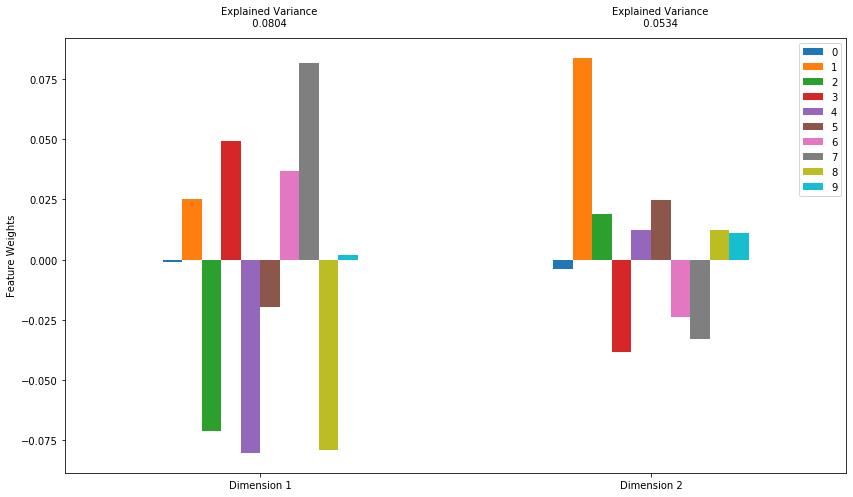

In [423]:
# plot an illustraion 
pca_results(azdias_cleaned,pca);

In [225]:
def map_pca(pca,df,index_component):
    
    ddf=pd.DataFrame(pca.components_[index_component,:].reshape(1,-1),columns=df.columns).iloc[0,:].sort_values(ascending=False)
    
    return ddf

In [226]:
map_pca(pca,azdias_lm,0)

KBA13_ANTG1                   0.141637
PLZ8_ANTG1                    0.140946
MOBI_REGIO                    0.134509
MOBI_RASTER                   0.132228
KBA13_AUTOQUOTE               0.129665
KBA05_ANTG1                   0.125247
KBA05_GBZ                     0.122918
GEMEINDETYP                   0.110183
KBA13_GBZ                     0.106492
FINANZ_MINIMALIST             0.105902
PLZ8_GBZ                      0.104309
KBA13_ALTERHALTER_60          0.102333
D19_GESAMT_ANZ_24             0.101629
KONSUMNAEHE                   0.100931
KBA13_HALTER_55               0.097644
KBA05_ANHANG                  0.097130
INNENSTADT                    0.096284
ONLINE_AFFINITAET             0.094951
D19_VERSAND_ANZ_24            0.094261
D19_GESAMT_ANZ_12             0.094253
KBA13_HALTER_50               0.091623
KBA05_AUTOQUOT                0.090350
type_of_bulding               0.087357
D19_VERSAND_ANZ_12            0.086316
FIRMENDICHTE                  0.084847
KBA13_KRSAQUOT           

In [227]:
map_pca(pca,azdias_lm,1)

KBA13_HERST_BMW_BENZ           0.180465
KBA13_MERCEDES                 0.155844
KBA13_SEG_OBEREMITTELKLASSE    0.153557
KBA13_BMW                      0.148800
KBA13_SITZE_4                  0.142578
KBA13_SEG_SPORTWAGEN           0.139027
KBA13_KMH_211                  0.128320
KBA13_KMH_250                  0.126097
KBA13_KW_121                   0.125127
KBA05_HERST1                   0.122295
KBA13_CCM_2501                 0.120548
KBA13_SEG_OBERKLASSE           0.119231
OST_WEST_KZ                    0.113966
KBA05_KW3                      0.113004
KBA13_CCM_3000                 0.111833
KBA13_KRSHERST_BMW_BENZ        0.110830
KBA13_CCM_3001                 0.107916
KBA05_MOTOR                    0.103420
KBA05_MOD1                     0.103259
KBA05_CCM4                     0.101349
KBA13_HALTER_65                0.100727
KBA05_SEG5                     0.091572
KBA13_CCM_2500                 0.089846
LNR                            0.083767
KBA05_SEG8                     0.080673


In [228]:
pca.components_.shape

(128, 332)

### Part 1.4 : Apply Clustering

In [229]:
# Over a number of different cluster counts...
def run_clustering (dataset,n_clusters):
    model =MiniBatchKMeans(n_clusters=n_clusters,max_iter=200, batch_size=10000)
    model.fit(dataset)
    
    return model.score(dataset)

In [230]:
error_score=[]
cn=list(np.arange(10,50,1))
for i in cn:
    error_score.append(np.abs(run_clustering(azdias_pca,i)))

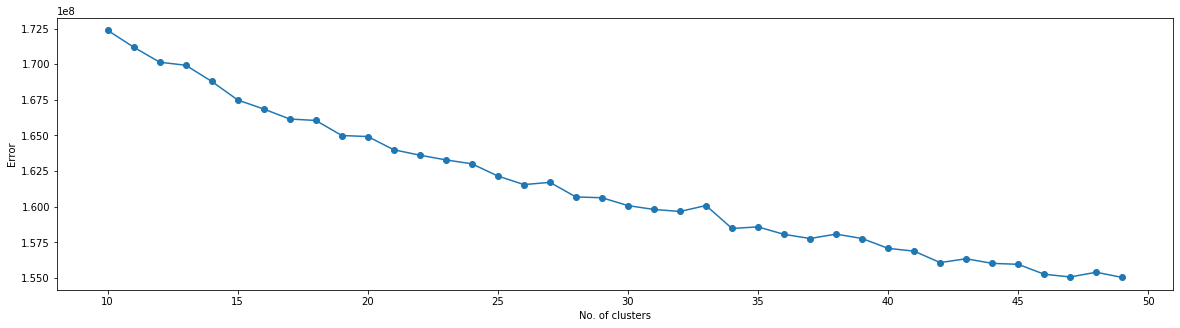

In [444]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(20,5))
plt.plot(cn,error_score,marker='o');
plt.ylabel('Error');
plt.xlabel('No. of clusters');


In [232]:
# Re-fitting the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
model = KMeans(n_clusters=37)
model.fit(azdias_pca)
model_pre = model.predict(azdias_pca)

### Part 1.4 : Compare Customer Data to Demographics Data

In [233]:
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv')

/Users/hussam/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [234]:
col_not= []
for c in customers_orig.columns:
    if c in azdias_orig.columns:
        continue
    else: 
        col_not.append(c)

In [235]:
customers.drop(columns = col_not , inplace = True)

In [236]:
customers_cleaned = clean_data(customers)

In [237]:
customers_cleaned.columns

Index(['Unnamed: 0', 'LNR', 'AKT_DAT_KL', 'ALTER_HH', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL',
       ...
       'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'neighborhood_quality', 'ANREDE_KZ', 'ALTERSKATEGORIE_GROB',
       'CAMEO_INTL_wealth', 'CAMEO_INTL_life_stage'],
      dtype='object', length=332)

In [238]:
customers_cleaned.shape

(140180, 332)

In [239]:
azdias_lm.shape

(784267, 332)

In [240]:
col_not=[]

for c in azdias_lm.columns:
    if c not in customers_cleaned.columns :
        col_not.append(c)

In [241]:
col_not

[]

In [242]:
cidf = pd.DataFrame(im.transform(customers_cleaned))

In [243]:
#Scaling
cssdf = pd.DataFrame(ss.transform(cidf))

In [244]:
# Apply pca
cpca = pca.transform(cssdf)

In [245]:
#predict clusters
c_model_pre = model.predict(cpca)

Text(0.5, 1.0, 'General Clusters')

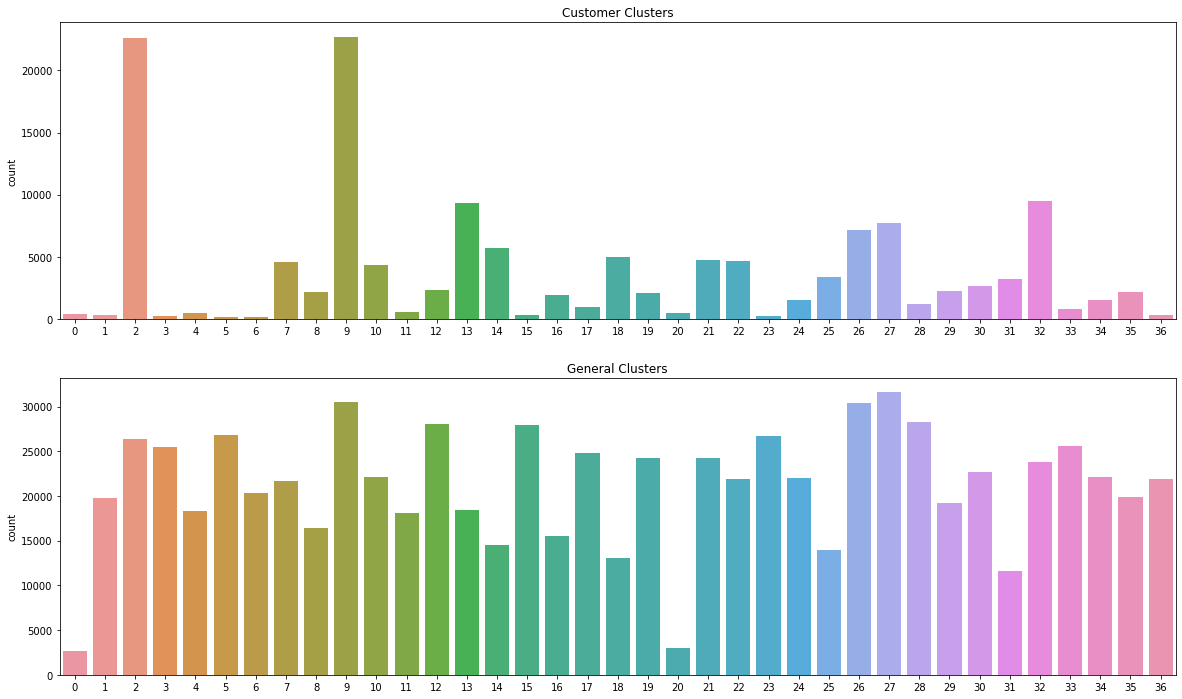

In [446]:
figure, axs = plt.subplots(nrows=2, ncols=1, figsize = (20,12))
figure.subplots_adjust(hspace = 0.2, wspace=0)

sns.countplot(c_model_pre, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(model_pre, ax=axs[1])
axs[1].set_title('General Clusters')

In [448]:
centroid_2=ss.inverse_transform(pca.inverse_transform(model.cluster_centers_[2]))
overrepresented_c = pd.Series(data = centroid_2, index = customers_cleaned.columns)
overrepresented_c.sort_values()

ANZ_KINDER                        0.001726
SOHO_KZ                           0.008638
ANZ_TITEL                         0.011930
D19_TELKO_ANZ_12                  0.015072
ANZ_HH_TITEL                      0.022610
D19_BANKEN_ANZ_12                 0.026193
KBA05_ANTG4                       0.038360
D19_TELKO_ANZ_24                  0.043051
KBA05_ANTG3                       0.053464
UNGLEICHENN_FLAG                  0.053610
D19_BANKEN_ANZ_24                 0.063020
D19_VERSI_ANZ_12                  0.064356
D19_TIERARTIKEL                   0.094392
D19_DIGIT_SERV                    0.097094
D19_BANKEN_LOKAL                  0.100710
KONSUMZELLE                       0.102404
HH_DELTA_FLAG                     0.115822
D19_VERSI_ANZ_24                  0.128089
D19_GARTEN                        0.163171
D19_SCHUHE                        0.167949
D19_BANKEN_REST                   0.213478
D19_VERSAND_ANZ_12                0.219189
D19_FREIZEIT                      0.261649
D19_NAHRUNG

In [449]:
centroid_9=ss.inverse_transform(pca.inverse_transform(model.cluster_centers_[9]))
overrepresented_c = pd.Series(data = centroid_9, index = customers_cleaned.columns)
overrepresented_c.sort_values()

ANZ_TITEL                         0.006215
ANZ_HH_TITEL                      0.007082
KBA05_ANTG4                       0.009777
SOHO_KZ                           0.009808
KBA05_ANTG3                       0.020494
D19_TELKO_ANZ_12                  0.032976
D19_BANKEN_ANZ_12                 0.064282
KONSUMZELLE                       0.066206
UNGLEICHENN_FLAG                  0.074356
D19_TELKO_ANZ_24                  0.094135
ANZ_KINDER                        0.120135
KBA05_SEG6                        0.131060
D19_BANKEN_LOKAL                  0.141101
HH_DELTA_FLAG                     0.141923
D19_BANKEN_ANZ_24                 0.169887
D19_VERSI_ANZ_12                  0.179039
KBA13_ANTG4                       0.200062
PLZ8_ANTG4                        0.241999
D19_DIGIT_SERV                    0.313211
D19_VERSI_ANZ_24                  0.339241
D19_TIERARTIKEL                   0.406664
GREEN_AVANTGARDE                  0.547602
D19_BIO_OEKO                      0.615185
D19_NAHRUNG

In [468]:
attr_df.iloc[2219:2230]

,Unnamed: 0,Attribute,Description,Value,Meaning
2219,NaN,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2220,NaN,NaN,NaN,1,length of residence below 1 year
2221,NaN,NaN,NaN,2,length of residence 1-2 years
2222,NaN,NaN,NaN,3,length of residence 2-3 years
2223,NaN,NaN,NaN,4,length of residence 3-4 years
2224,NaN,NaN,NaN,5,length of residence 4-5 years
2225,NaN,NaN,NaN,6,length of residence 5-6 years
2226,NaN,NaN,NaN,7,length of residence 6-7 years
2227,NaN,NaN,NaN,8,length of residence 7-10 years
2228,NaN,NaN,NaN,9,length of residence more than 10 years


In [469]:
attr_df[11:32]

,Unnamed: 0,Attribute,Description,Value,Meaning
11,NaN,ALTER_HH,main age within the household,0,unknown / no main age detectable
12,NaN,NaN,NaN,1,01.01.1895 bis 31.12.1899
13,NaN,NaN,NaN,2,01.01.1900 bis 31.12.1904
14,NaN,NaN,NaN,3,01.01.1905 bis 31.12.1909
15,NaN,NaN,NaN,4,01.01.1910 bis 31.12.1914
16,NaN,NaN,NaN,5,01.01.1915 bis 31.12.1919
17,NaN,NaN,NaN,6,01.01.1920 bis 31.12.1924
18,NaN,NaN,NaN,7,01.01.1925 bis 31.12.1929
19,NaN,NaN,NaN,8,01.01.1930 bis 31.12.1934
20,NaN,NaN,NaN,9,01.01.1935 bis 31.12.1939


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [369]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', delimiter=',')

In [371]:
mailout_train.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [372]:
mailout_train.RESPONSE.head()

0    0
1    0
2    0
3    0
4    0
Name: RESPONSE, dtype: int64

In [373]:
mailout_train_cleaned = clean_data(mailout_train)
del mailout_train_cleaned['Unnamed: 0']

In [374]:
Y = mailout_train_cleaned.RESPONSE
X = mailout_train_cleaned.drop(columns = 'RESPONSE')

In [375]:
ss_train = StandardScaler(with_mean=True, with_std=True)
ss_train_df = pd.DataFrame(ss_train.fit_transform(X))

In [376]:
ss_train_df.columns = X.columns
ss_train_df.index = X.index

In [377]:
imp = Imputer(strategy='most_frequent')
i_train_df = pd.DataFrame(imp.fit_transform(ss_train_df))

/Users/hussam/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [380]:
i_train_df.isnull().sum().sum()

0

In [483]:
def classifier(clf, param_grid, X ,  Y ):
    """
    Fit a classifier using GridSearchCV
    
    INPUT:
    - clf: classifier to fit
    - param_grid: classifier parameters used with GridSearchCV
    - X features: of the training dataframe
    - Y Response: labels
            
    OUTPUT:
    Fitted classifier, Best score
    """
    
    grid = GridSearchCV(estimator = clf, param_grid = param_grid, scoring = 'roc_auc')
    grid.fit(X, Y)
    
    return grid, grid.best_estimator_ , grid.best_score_

In [453]:
# Random Forest Classifier
randomforest = RandomForestClassifier()
randomforest_score = classifier(randomforest,X = i_train_df, Y = Y ,param_grid= {'n_estimators': [100,200]})[1]

/Users/hussam/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [454]:
# Adaptive Boosting Classifier
adaboost = AdaBoostClassifier()
adaboost_score = classifier(adaboost, X = i_train_df, Y = Y , param_grid = {'learning_rate': [0.01,0.001] ,'n_estimators':[50,100] } )[1]

/Users/hussam/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [455]:
# Logistic Regression Classifer
logreg = LogisticRegression()
logreg_score = classifier(logreg, X = i_train_df, Y = Y , param_grid = {} )[1]

/Users/hussam/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/hussam/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hussam/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hussam/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hussam/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: Fut

In [456]:
# Support Vector Classifier
svc = SVC()
svc_score = classifier(svc, X = i_train_df, Y = Y , param_grid = {} )[1]

/Users/hussam/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/hussam/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/hussam/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/hussam/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default va

In [484]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier()
gbc_model, gbc_best_estimators, gbc_score = classifier(gbc, X = i_train_df, Y = Y , param_grid = {'learning_rate':[0.01,0.001]})

/Users/hussam/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [485]:
pd.DataFrame({'Model':['Random Forest Classifier','Adaptive Boosting Classifier','Logistic Regression Classifer',
                      'Support Vector Classifier', 'Gradient Boosting Classifier'],
              'Score':[randomforest_score, adaboost_score, logreg_score, svc_score, gbc_score] })

,Model,Score
0,Random Forest Classifier,0.566741
1,Adaptive Boosting Classifier,0.687744
2,Logistic Regression Classifer,0.641249
3,Support Vector Classifier,0.596823
4,Gradient Boosting Classifier,0.719000


### Reflection:
The Goal of this project is to predict individuals who are most likely to become customers for a mail-order sales company in Germany.
#### we've used the datasets provided by Arvato:
####  AZDIAS: Demographics data for the general population of Germany.
####  CUSTOMERS: Demographics data for customers of a mail-order company.

Then we've performed the data exploration and assessed the missing values and dropped the rows and columns which had a high amount of missing values. After that, we performed imputation and scaled the features to feed the data into clustring using 37 cenntroids on the demographic dataset and done it on customers datasets to see where both data overlaps to target the potential customers. Then, we tried to use supervised learning on the mailout_test datasets and measured the scores of the AUC ROC, The model that scored the best was Gradient Boosting Classifier.

### Improvement:

I've tried using several models and scored the output to find the best possible model. The best score was for `Gradient Boosting Classifier` with 71%. Further tuning to  cann done through iterating :
#### `learning_rate` :learning rate shrinks the contribution of each tree.
#### `n_estimators` :  The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
This could result in better score, but running the model takes a lot of time and i wasn't able to further perform the analysis due to time deadline. 

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [545]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv',delimiter=',')
del mailout_test['Unnamed: 0']

/Users/hussam/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [546]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [547]:
mailout_test_cleaned = clean_data(mailout_test)

In [548]:
mailout_test_cleaned.shape

(34958, 331)

In [549]:
ss_test = StandardScaler(with_mean=True, with_std=True)
ss_test_df = pd.DataFrame(ss_test.fit_transform(mailout_test_cleaned))

In [550]:
ss_test_df.shape

(34958, 331)

In [551]:
ss_test_df.columns = mailout_test_cleaned.columns
ss_test_df.index = mailout_test_cleaned.index

In [552]:
imp = Imputer(strategy='most_frequent')
i_test_df = pd.DataFrame(imp.fit_transform(ss_test_df))

/Users/hussam/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [553]:
i_test_df.shape

(34958, 331)

In [561]:
RESPONSE = gbc_model.predict_proba(i_test_df,)

In [562]:
kaggle = pd.DataFrame({'LNR':mailout_test_cleaned.LNR, 'Response':RESPONSE[:,1]})

In [563]:
kaggle.head()

,LNR,Response
0,1754,0.015867
1,1770,0.024296
2,1465,0.006263
3,1470,0.006688
4,1478,0.009616


In [564]:
kaggle.to_csv('submission.csv')